## Sentiment Analysis


In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
from scipy import stats
from pandas.plotting import scatter_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word

plot_size = plt.rcParams["figure.figsize"]  

plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianjetz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julianjetz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/julianjetz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, na_values=na_values)

In [4]:
ira_data.insert(4, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

In [5]:
ira_data.head(10)

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_ID,AD_CLICKS_PER_VIEW,AD_IMPRESSIONS,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,...,AD_TARGETING_GENDER,AD_TARGETING_INTERESTS,AD_TARGETING_LANGUAGE,AD_TARGETING_LOCATION,AD_TARGETING_LOCATION_LIVING_IN,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET
0,6.0,2015-10-25 06:28:33,2015-10-27 23:59:00,1,0.016760,358.0,https://www.instagram.com/us_daily/,2015-q4/2015-10/P(1)0001736.pdf,161.23 RUB,18 - 51,...,NaN,"News broadcasting, Political party, Breaking n...",English (US),NaN,United States,NaN,NaN,Instagram Feed,Instgogogo,52000000.0
1,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,2,0.002202,17256.0,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,...,NaN,NaN,NaN,NaN,United States: Texas,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0
2,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,3,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,...,NaN,Cop Block or Black (Color),English (US),NaN,United States,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0
3,33.0,2016-04-19 07:49:45,NaT,4,0.002306,14311.0,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,...,NaN,Cop Block,English (US),United States,NaN,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0
4,201.0,2016-06-15 03:39:52,NaT,5,0.006748,29786.0,https://www.facebook.com/govspending-165176135...,2016-q2/2016-06/P(1)0000001.pdf,3714.15 RUB,18 - 65+,...,NaN,Understanding racial segregation in the united...,NaN,NaN,United States: Georgia,NaN,NaN,Instagram Feed,WHERE is your VOICE?,NaN
5,NaN,2016-05-12 04:06:17,NaT,6,NaN,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
6,54.0,2016-05-13 01:18:08,NaT,7,0.002307,23408.0,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
7,43.0,2016-03-11 05:04:42,NaT,8,0.004498,9559.0,https://www.instagram.com/black—america—today/,2016-q1/2016-03/P(1)0006379.pdf,2003.01 RUB,13 - 35,...,NaN,Hoodies or Trayvon Martin,English (UK)or English (US),United States,NaN,NaN,NaN,Instagram Feed,Trayvon Martin's lawyers wearing hoodies. Wear...,18000.0
8,13.0,2015-11-24 05:34:21,NaT,9,0.002669,4871.0,https://www.instagram.com/veterans_us/,2015-q4/2015-11/P(1)0001229.pdf,1052.89 RUB,18 - 65+,...,NaN,"Veterans Day, American Revolutionary War or Pa...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Edward was a combat engineer in Afghanistan wh...,3600000.0
9,11.0,2015-11-16 05:49:20,NaT,10,0.006769,1625.0,https://www.instagram.com/gov_spending/,2015-q4/2015-11/P(1)0001747.pdf,662.39 RUB,18 - 65+,...,NaN,"United States Senate, Election, Government or ...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Unbelievable amount of the US government's was...,29000000.0


### Extract Hashtags
Extracting the Hashtags in case they are needed later

In [6]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", str(i))
        hashtags.append(ht)

    return hashtags

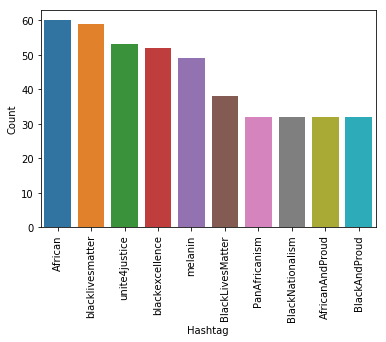

In [7]:
HT = hashtag_extract(ira_data['AD_TEXT'])
HT = sum(HT,[])

a = nltk.FreqDist(HT)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
#d.plot.bar()
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Add column with word count

In [8]:
ira_data['WORD_COUNT'] = ira_data['AD_TEXT'].apply(lambda x: len(str(x).split(" ")))
ira_data = ira_data[ira_data['WORD_COUNT'] > 4]

### Remove hyperlinks

In [9]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

### Removal of stopwords

In [10]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_TEXT']
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))

1       You go hell follow @south_lone_star instead! T...
2       Black lives matter see what's going on. We car...
3       Don't Shoot community site find recent videos ...
5       Conservative Christians. Pro-life/ gun/ police...
6       Conservative Christians. Pro-life/ gun/ police...
7       Trayvon Martin's lawyers wearing hoodies. Wear...
8       Edward combat engineer Afghanistan whose job c...
9       Unbelievable amount US government's waste. Joi...
10      Veterans Day coming! There many ways show supp...
11      It's time us understand deserve best. It's tim...
12      The original Statue Liberty France black. The ...
13      This military campaign ambiguous given cost ne...
14      And would choose u president: create 11200 mil...
15      A Wounded Warrior service dog. Support Veteran...
16      What know PTSD? There greater agony. PTSD affe...
17      What know PTSD? There greater agony. PTSD affe...
18      Who save children? Click Learn more! The US Go...
19      Click 

### Removal of words with less than 5 characters

In [11]:
# ira_data['AD_TEXT'] = ira_data['AD_TEXT'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>4]))

### Stemming
removal of suffices, like “ing”, “ly”, “s”, etc. 

In [12]:
st = PorterStemmer()
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

1       you can go to hell or follow @south_lone_star ...
2       black live matter becaus we see what' go on. W...
3       don't shoot is a commun site where you can fin...
5       conserv christians. pro-life/ gun/ police/ mil...
6       conserv christians. pro-life/ gun/ police/ mil...
7       trayvon martin' lawyer wear hoodies. wear hood...
8       edward wa a combat engin in afghanistan whose ...
9       unbeliev amount of the US government' waste. j...
10      veteran day is coming! there are so mani way t...
11      it' time for us to understand that we do deser...
12      the origin statu of liberti in franc is black....
13      thi militari campaign is veri ambigu given tha...
14      and what would you choos if u were a president...
15      A wound warrior and hi servic dog. support our...
16      what do you know about ptsd? there is no great...
17      what do you know about ptsd? there is no great...
18      who will save the children? click learn more! ...
19      click 

### Lemmatization
converts the word into its root word

In [13]:
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

1       You can go to hell or follow @south_lone_star ...
2       Black life matter because we see what's going ...
3       Don't Shoot is a community site where you can ...
5       Conservative Christians. Pro-life/ gun/ police...
6       Conservative Christians. Pro-life/ gun/ police...
7       Trayvon Martin's lawyer wearing hoodies. Weari...
8       Edward wa a combat engineer in Afghanistan who...
9       Unbelievable amount of the US government's was...
10      Veterans Day is coming! There are so many way ...
11      It's time for u to understand that we do deser...
12      The original Statue of Liberty in France is bl...
13      This military campaign is very ambiguous given...
14      And what would you choose if u were a presiden...
15      A Wounded Warrior and his service dog. Support...
16      What do you know about PTSD? There is no great...
17      What do you know about PTSD? There is no great...
18      Who will save the children? Click Learn more! ...
19      Click 

### Lowercase

In [14]:
ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].str.replace('[^\w\s]','')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].str.replace("[^a-zA-Z#]", " ")

In [15]:
ira_data['AD_CLEANED_TEXT'] = ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

### Common word removal
Removes the 10 most common words

In [16]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[:10]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

### Rare words removal
Removes the 10 most uncommon words

In [17]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[-10:]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [18]:
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(x).split())

### Spelling correction
check for ur etc. before correction

In [19]:
# ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(TextBlob(x).correct()))

## Sentiment Analysis with TextBlob

In [20]:
ira_data['AD_TextBlob_POLARITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[0] )
ira_data['AD_TextBlob_SUBJECTIVITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[1] )

In [21]:
ira_data['AD_TextBlob_Sentiment'] = ira_data['AD_TextBlob_POLARITY'].apply(lambda x: 'positive' if x>0 else ('neutral' if x == 0 else 'negative'))

In [22]:
ira_data.head()

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_ID,AD_CLICKS_PER_VIEW,AD_IMPRESSIONS,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,...,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET,WORD_COUNT,AD_CLEANED_TEXT,AD_TextBlob_POLARITY,AD_TextBlob_SUBJECTIVITY,AD_TextBlob_Sentiment
1,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,2,0.002202,17256.0,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,...,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0,37,you can go to hell or follow south lone star i...,0.000000,0.000000,neutral
2,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,3,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,...,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0,43,black lives matter because we see whats going ...,-0.166667,0.433333,negative
3,33.0,2016-04-19 07:49:45,NaT,4,0.002306,14311.0,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,...,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0,38,dont shoot is a community site where you can f...,-0.075000,0.487500,negative
5,NaN,2016-05-12 04:06:17,NaT,6,NaN,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,...,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians prolife gun police mil...,-0.100000,0.100000,negative
6,54.0,2016-05-13 01:18:08,NaT,7,0.002307,23408.0,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,...,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0,7,conservative christians prolife gun police mil...,-0.100000,0.100000,negative


Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using TextBlob')

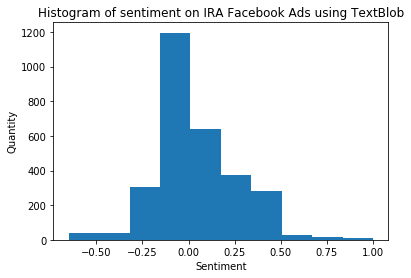

In [23]:
polarity=ira_data[ira_data['AD_TextBlob_SUBJECTIVITY'] < 0.8]
plt.hist(polarity['AD_TextBlob_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Quantity')
plt.title('Histogram of sentiment on IRA Facebook Ads using TextBlob')

Text(0.5, 1.0, 'Histogram of subjectivity on IRA Facebook Ads')

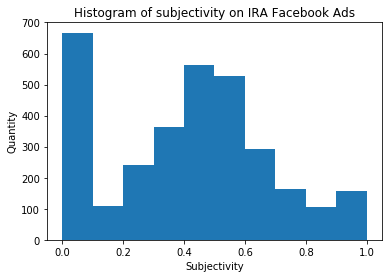

In [24]:
plt.hist(ira_data['AD_TextBlob_SUBJECTIVITY'])
plt.xlabel('Subjectivity')
plt.ylabel('Quantity')
plt.title('Histogram of subjectivity on IRA Facebook Ads')

## Sentiment Analysis with VADER

In [25]:
analyzer = sid()
ira_data['AD_VADER_POLARITY']=ira_data['AD_TEXT'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
ira_data['AD_VADER_Sentiment'] = ira_data['AD_VADER_POLARITY'].apply(lambda x: 'positive' if x>=0.5 else ('negative' if x <= -0.5 else 'neutral'))
ira_data['AD_VADER_Sentiment'].value_counts()

positive    1162
neutral     1160
negative     871
Name: AD_VADER_Sentiment, dtype: int64

Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using VADER')

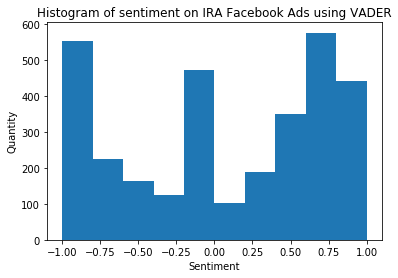

In [26]:
plt.hist(ira_data['AD_VADER_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Quantity')
plt.title('Histogram of sentiment on IRA Facebook Ads using VADER')

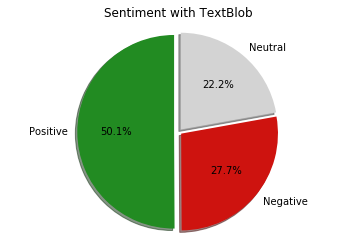

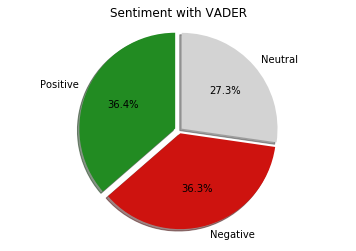

In [27]:
# TODO Change colour of pos and neg so that they are the same

fig1, ax1 = plt.subplots()
explode = (0.05, 0.03, 0.03)
labels='Positive', 'Negative', 'Neutral'
colors=['forestgreen', '#CE130F', 'lightgrey']
ax1.pie(ira_data['AD_TextBlob_Sentiment'].value_counts(), labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal') 
plt.title('Sentiment with TextBlob')
fig2, ax2 = plt.subplots()
ax2.pie(ira_data['AD_VADER_Sentiment'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax2.axis('equal') 
plt.title('Sentiment with VADER')

plt.show()

* * * * * * * * * *


### Most Common words

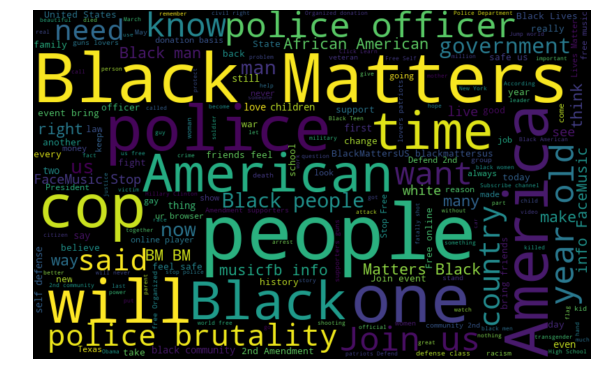

In [28]:
all_words = ' '.join([text for text in ira_data['AD_TEXT']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Most Common words in positive Ads

In [29]:
ira_data = ira_data[ira_data['AD_TextBlob_Sentiment']==ira_data['AD_VADER_Sentiment']]

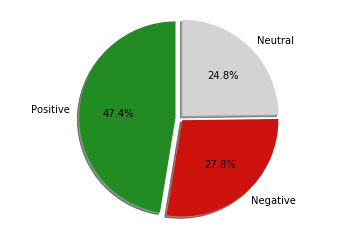

In [30]:
fig1, ax1 = plt.subplots()
explode = (0.05, 0.03, 0.03)
labels='Positive', 'Negative', 'Neutral'
colors=['forestgreen', '#CE130F', 'lightgrey']
ax1.pie(ira_data['AD_VADER_Sentiment'].value_counts(), labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal') 
plt.show()

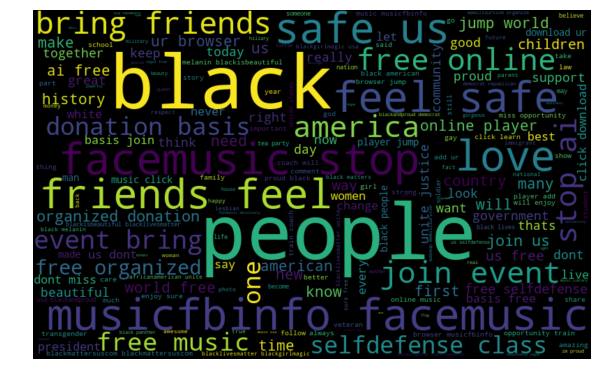

In [31]:
pos_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_VADER_Sentiment'] =="positive"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Most Common words in negative Ads

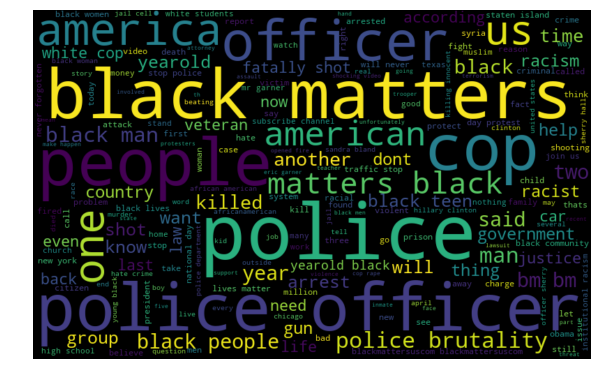

In [32]:
neg_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_VADER_Sentiment'] =="negative"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [33]:
pd.set_option('display.max_colwidth', -1)
ira_data[ira_data['AD_VADER_Sentiment'] == "negative"][['AD_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
2504,Dam ieon Flowers' video of a confrontation between a cop and three Black juveniles went viral on social media. The frequency at which ordinary stops by the police escalate into horrible and sometimes fatal encounters has led to a high level of distrust between Black comm Damieon Flowers: Those Boys Had Fear In Their Eyes So I Stepped In I BM BM,-0.231667,-0.9423
3020,"For last 1,000 days, America and its allies have killed at least 3,200 civilians in Syria. But will bombing bring peace? Martin Luther King Jr. had an answer on that: ""The chain reaction of evil - hate begetting hate, wars producing more wars - must be broken, or we shall be plunged into the dark abyss of annihilation.""",-0.350000,-0.9753
265,She only allowed her son to drive a golf cart. A beautiful family who always take a yearly vacation at the luxury resort on Bald Head Island met a horrible experience this year as soon as they met with polic Mom Brutalized And Jailed For Presumptuous Child Abuse I Black Matters Black Matters,-0.096667,-0.8807
2439,Many of us are poor and struggling due to systemic racism!! So fight for something! IT IS OUR DUTY!! WE HAVE NOTHING TO LOSE BUT OUR CHAINS!,-0.008333,-0.7727
2312,Institutional racism takes a hold of our schools as white students of the University of North Dakota make a mockery of Black people. Institutional Racism: White Students Slam BLM I BM BM,-0.055556,-0.9201
1037,"One of our subscribers asked us to join #HillaryClintonForPrison2016 Flash mob. ARE YOU READY FOR A FLASH MOB, BLACKTIVISTS? If Hillary and her party have done so much for us, why is poverty increasing in the black community? Why we can't see economic development? Why there are no jobs for us? Why black unemployment rate is twice as the national average? She wasn't for us here before the elections, remember? If these questions are asked more often, it will be another disappointing Election Day for Hillary Clinton. Take part in this flash mob and show everybody that no one can manipulate black voters. Take a picture with a hashtag #HillaryClintonForPrison2016 => Sign the petition and spread the truth.",-0.016667,-0.6516
1570,Let's fight against police brutality together! donotshoot.us Don't Shoot Donotshoot.us A 15-year-old teenager was assaulted by an off-duty officer during a violent brawl. Donotshoot.us The video shows SWAT team in attempt to raid the wrong home without a warrant Donotshoot.us This short video shows the bloody scuffle that took place during the forceful arrest of a homeless man Terre Johnson. Don't Shoot,-0.430000,-0.9613
3383,Revealing the uncomfortable truth and exposing the liberal media bias! Let's get red pilled!,-0.250000,-0.5242
243,"A Public Defender posed a controversial question to potential Jurors for the trial of a young Black man convicted of murder. The question indicated to an increasing awareness among public defenders that they too may harbor racial and ethnic biases about Blacks. Earlier this year, San Francisco public defender, Mark Jacobs, posed a shocking question to a group of jurors prior to the trial of a young black man. The quest Racial Incongruities In U.S. Criminal Justice System I Black Matters Black Matters",-0.087778,-0.7845
841,"A young black guy who was mentally disabled decided to end his life, but will only do that by making the cops kill him. This is absolutely insane in the highest order. He took a gun and ordered his other two brothers to take a video of the whole incident. Michael Ford, at the police vicinity opened fire and got the cop's attention. The filming was still in process as he commanded. The first cops who appeared fired back and almost immediately ended up drawing fire. He gave the other officer a chance to get into position when he opened fire. It's quite not understandable why his own cop shot him and shot the mentality ill man too. This is a good example of sick reality too. Is there any explanation why cops have started 

In [34]:
ira_data[ira_data['AD_VADER_Sentiment'] == "positive"][['AD_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
2883,Together we are a shining beacon of faithfulness! Join us and light your way to Jesus!,0.400000,0.6892
674,"Everyday news, updates, coming outs and much more! United we stand!",0.150000,0.5686
954,This hairdresser from Atlanta is amazing. She can install locs at supersonic speeds. This hairdresser from Atlanta is amazing. She can install locs...,0.600000,0.8225
2477,"+size princess(we don't know her name, her Twitter account is @_illestCee) was body-shamed by some man on the Internet. Zendaya came across his comments on Twitter and decided to step in. ""Stumbling across this is stupid shit, she is fine as hell head to toe. [I] guarantee [she] doesn't know you exist my man. As for her, slay on queen,"" she tweeted and offered @_illestCee a modeling gig! ""I'm really speechless right now because becoming a plus size model has been my number one goal,"" the beauty replied. Black girl magic works! Don't try to mess with it! Especially when two black girls unite for a good purpose! Respect people! #blackexcellence #blackperfection #blackbeauty #blackbusiness #africanamerican #blackcommunity #melanin #blackpride #blackout #america #usa #blackscience #education #diversity #zendaya",0.087004,0.5541
3443,Free online player! Jump in the world of free music! Click and download for ur browser musicfb.info FaceMusic Stop A.I.,0.400000,0.7170
3354,"The first self-defense class Join the event, bring your friends, feel safe with us!!! Self-defense classes",0.375000,0.8433
514,"Free the patriots, stand for liberty and our rights!",0.400000,0.7901
2683,Love that is earned is actually more stable,0.500000,0.7713
3423,"A tiny browser extension will help you to browse, listen and share any kind of music! Free online music library! musicfb.info FaceMusic Stop A.I.",0.333333,0.7639
300,"A new BlackMattersUS tool gathers all the Black meetups in one place. Now you can keep track of and organize ALL the Black meetups in one place! We are glad to be the first and only platform that provides this opportunity. For those who want to make real changes; we offer a convenient search of the upcoming and past events. For the organizers; we suggest the free promotion of your events to more than 300,000 of event-goers via all the social media! All copyrights remain with original owners. Now it is easy to search for a meetup in your area:",0.172669,0.9396


In [35]:
ira_data['AD_VADER_Sentiment'].value_counts()

positive    809
negative    474
neutral     423
Name: AD_VADER_Sentiment, dtype: int64

In [36]:
ira_data['AD_TextBlob_Sentiment'].value_counts()

positive    809
negative    474
neutral     423
Name: AD_TextBlob_Sentiment, dtype: int64

In [37]:
corrdf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_VADER_POLARITY']]
corrdf = corrdf.dropna()
print(corrdf.shape[0])
corrdf = corrdf[(np.abs(stats.zscore(corrdf)) < 3).all(axis=1)]
print(corrdf.shape[0])



1236
1209


In [38]:
ira_data.shape[0]

1706

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.830645,0.545445,-0.193746
AD_IMPRESSIONS,0.830645,1.000000,0.105875,-0.175331
AD_CLICKS_PER_VIEW,0.545445,0.105875,1.000000,-0.125189
AD_VADER_POLARITY,-0.193746,-0.175331,-0.125189,1.000000


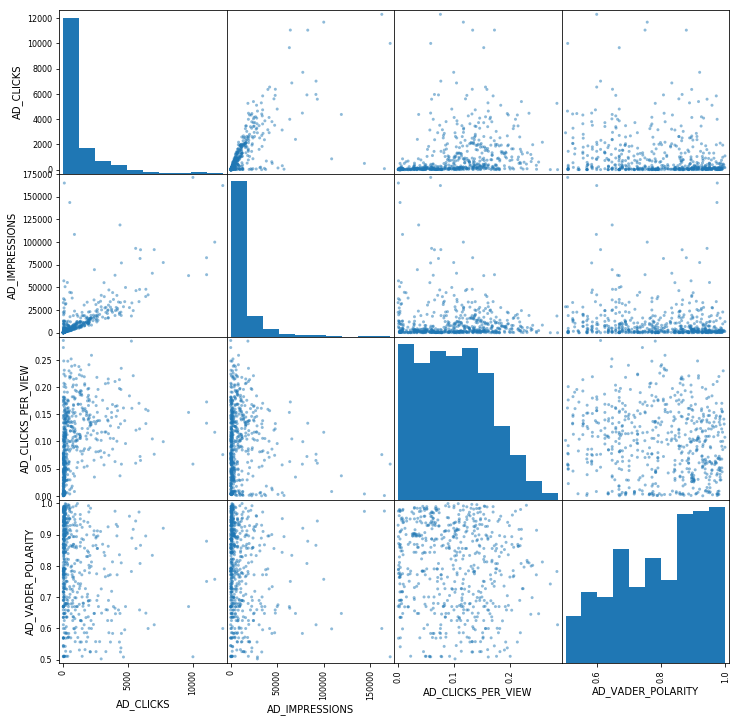

In [39]:
#positive ads corr
scatter_matrix(corrdf[corrdf['AD_VADER_POLARITY'] >= 0.5], figsize=(12, 12))
corrdf[corrdf['AD_VADER_POLARITY'] >= 0.5].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.939358,0.296135,0.059991
AD_IMPRESSIONS,0.939358,1.000000,0.011623,0.079996
AD_CLICKS_PER_VIEW,0.296135,0.011623,1.000000,-0.066699
AD_VADER_POLARITY,0.059991,0.079996,-0.066699,1.000000


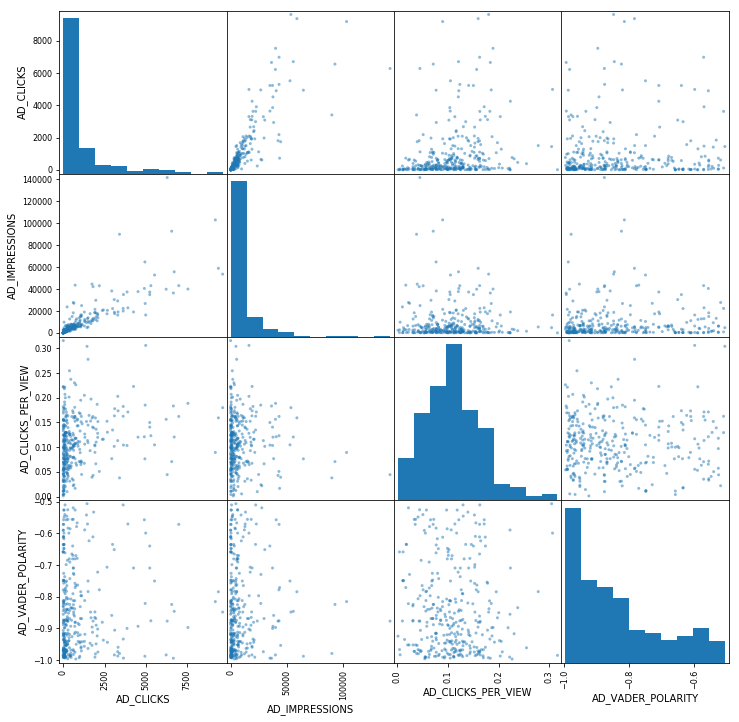

In [40]:
#negative ads corr
scatter_matrix(corrdf[corrdf['AD_VADER_POLARITY'] <= -0.5], figsize=(12, 12))
corrdf[corrdf['AD_VADER_POLARITY'] <= -0.5].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.898294,0.426308,0.057634
AD_IMPRESSIONS,0.898294,1.000000,0.103821,0.112257
AD_CLICKS_PER_VIEW,0.426308,0.103821,1.000000,-0.081001
AD_VADER_POLARITY,0.057634,0.112257,-0.081001,1.000000


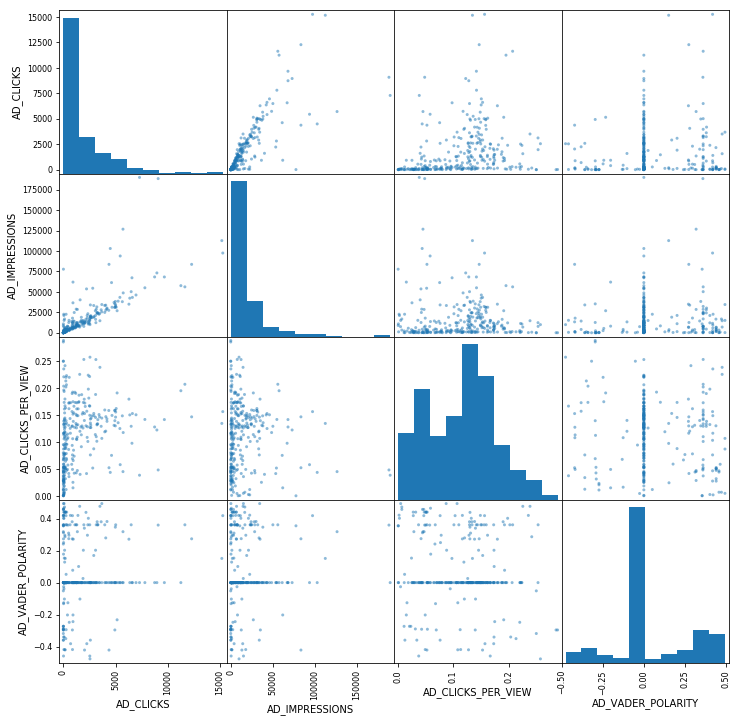

In [41]:
#neutral ads corr
scatter_matrix(corrdf[(corrdf['AD_VADER_POLARITY'] > -0.5) & (corrdf['AD_VADER_POLARITY'] < 0.5)], figsize=(12, 12))
corrdf[(corrdf['AD_VADER_POLARITY'] > -0.5) & (corrdf['AD_VADER_POLARITY'] < 0.5)].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.876759,0.469283,-0.098040
AD_IMPRESSIONS,0.876759,1.000000,0.099396,-0.035576
AD_CLICKS_PER_VIEW,0.469283,0.099396,1.000000,-0.108417
AD_VADER_POLARITY,-0.098040,-0.035576,-0.108417,1.000000


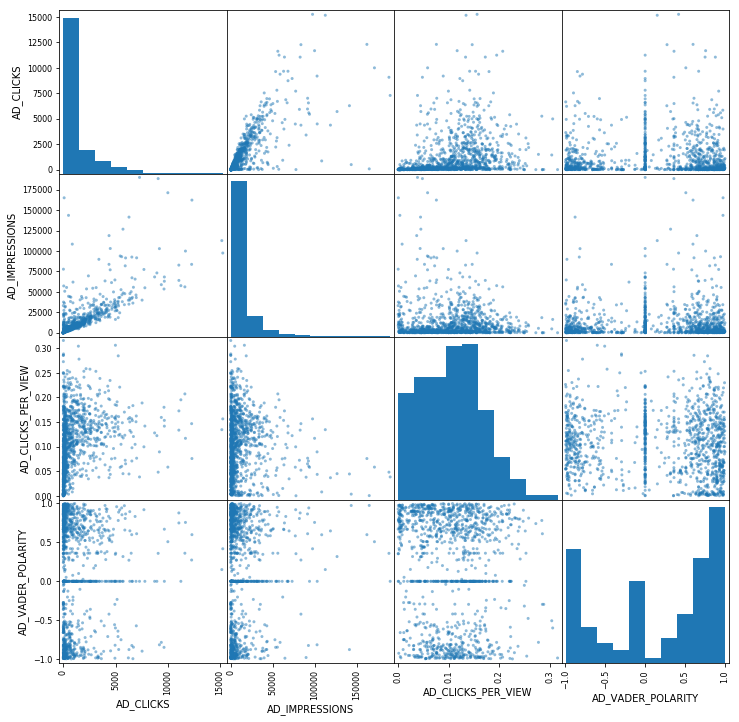

In [42]:
#all ads corr
scatter_matrix(corrdf, figsize=(12, 12))
corrdf.corr(method ='spearman') 

In [51]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentence = str(ira_data[ira_data['AD_ID']==725]['AD_TEXT'])
tokenized_sentence = nltk.word_tokenize(sentence)

sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in tokenized_sentence:
    if (sid.polarity_scores(word)['compound']) >= 0.05:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.05:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)                

print('Positive:',pos_word_list)        
print('Neutral:',neu_word_list)    
print('Negative:',neg_word_list) 
score = sid.polarity_scores(sentence)
print('\nScores:', score)

Positive: ['strong', 'treat', 'like', 'committed', 'free', 'ready', 'commitment', 'liberty', 'wins', 'peacefully', 'ready', 'Invite', 'friends', 'Ready']
Neutral: ['724', 'Fellow', 'Texans', '!', 'It', "'s", 'time', 'to', 'say', 'a', 'to', 'the', 'establishment', 'robbers', '.', 'It', 'is', 'for', 'us', 'to', 'see', 'them', 'all', 'we', "'ve", 'been', 'building', 'for', 'decades', '.', 'For', 'centuries', '.', 'The', 'establishment', 'thinks', 'they', 'can', 'us', 'sheep', 'but', 'they', 'are', '.', 'We', 'wo', "n't", 'put', 'up', 'with', 'this', 'anymore', '.', 'The', 'corrupt', 'media', 'does', 'not', 'talk', 'about', 'the', 'crimes', 'by', 'Killary', 'Clinton', ',', 'neither', 'does', 'it', 'mention', 'the', 'emails', 'but', 'it', 'would', 'rather', 'keep', 'on', 'kicking', 'around', 'some', 'outdated', 'tapes', 'featuring', 'Trump', '.', 'Even', 'Republicans', 'are', 'now', 'offering', 'her', 'a', 'victory', 'by', 'renouncing', 'their', 'nominee', '.', 'What', 'is', 'this', 'if', '

In [56]:
sid.polarity_scores(str(ira_data[ira_data['AD_ID']==725]['AD_TEXT']))

{'neg': 0.158, 'neu': 0.643, 'pos': 0.199, 'compound': 0.899}

In [65]:
ira_data[['AD_ID', 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_TEXT']].sample(3) 

,AD_ID,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_TEXT
2067,2068,703.0,6583.0,0.106790,"Our deepest condolences to the victims and families in Manchester. We also wish people dedicate their sadness and thoughts to Syria, Flint, Bangkok or any other country which suffered from attacks and where the government cares only about money, not citizens."
1285,1286,48.0,2764.0,0.017366,Your voice counts! We are against illegal immigration!
1060,1061,2056.0,11932.0,0.172310,"Anyways, nobody is listening to us."
